In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.2)
%matplotlib inline
color = sns.color_palette()

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

In [ ]:
# prior 구매내역 가져오기
df = pd.read_pickle(PATH + 'prior_df.pkl')

user_feats = pd.read_pickle(PATH + 'user_feats.pkl')
prod_feats = pd.read_pickle(PATH + 'prod_feats.pkl')
user_prod_feats = pd.read_pickle(PATH + 'user_prod_feats.pkl')
orders = pd.read_pickle(PATH + 'orders.pkl')

In [ ]:
train_df = pd.read_pickle(PATH + 'train_df.pkl')

In [ ]:
train_df.head()

array([0], dtype=int8)

# 유저별로 전체 주문에서 50%가 넘는 요일, 시간, 재구매기간을 뽑고 같은 유저들끼리 묶는다. 

1. 먼저 유저별로 전체 주문 수를 알아야한다. -> user_feats에서 사용
2. 유저별로 요일, 시간, 재주문 기간을 카운트해서 유저의 전체 주문 수로 나눠준다. 
3. 40%가 넘는 요일, 시간, 기간이 있다면 해당 값을 유저 대표값으로 사용
4. 같은 대표값을 갖는 유저들끼리 모아서 구매 패턴을 비교해본다.

In [ ]:
user_feats.head()

,user_id,U_total_orders,U_total_products,U_unique_products,U_total_reorders,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1
0,1,10,59,18,41.0,10.0,5.900000,0.784259,6.0,6.0,9.0,0.666667,1.0,0.666667
1,2,14,195,102,93.0,37.0,13.928571,0.482419,19.0,9.0,16.0,0.578947,0.0,0.625000
2,3,12,88,33,55.0,19.0,7.333333,0.718710,6.0,5.0,6.0,0.833333,1.0,1.000000
3,4,5,18,17,1.0,1.0,3.600000,0.035714,7.0,2.0,3.0,0.142857,0.0,0.000000
4,5,4,37,23,14.0,8.0,9.250000,0.503704,9.0,5.0,12.0,0.444444,0.4,0.666667


In [ ]:
# 유저의 대표 요일
a = (orders[orders.eval_set == 'prior'].groupby(['user_id', 'order_dow']).size() / orders[orders.eval_set == 'prior'].groupby('user_id').order_number.max() >= 0.4).astype(np.uint8).reset_index().rename(columns={0 : 'dow'})
a = a[a['dow'] == 1]
a.reset_index(drop=True, inplace=True)
a.drop_duplicates('user_id', inplace=True)
a.drop('dow', axis=1, inplace=True)
a.rename(columns={'order_dow':'dow'}, inplace=True)
a

In [ ]:
# 유저의 대표 시간
b = (orders[orders.eval_set == 'prior'].groupby(['user_id', 'order_hour_of_day']).size() / orders[orders.eval_set == 'prior'].groupby('user_id').order_number.max() >= 0.4).astype(np.uint8).reset_index().rename(columns={0 : 'hod'})
b = b[b['hod'] == 1]
b.reset_index(drop=True, inplace=True)
b.drop_duplicates('user_id', inplace=True)
b.drop('hod', axis=1, inplace=True)
b.rename(columns={'order_hour_of_day':'hod'}, inplace=True)
b

,user_id,hod
0,4,11
2,5,18
3,6,18
4,8,0
5,10,15
...,...,...
40947,206173,16
40948,206183,13
40949,206197,18
40950,206198,16


In [ ]:
# 유저의 대표 재주문 기간
c = (orders[orders.eval_set == 'prior'].groupby(['user_id', 'days_since_prior_order']).size() / orders[orders.eval_set == 'prior'].groupby('user_id').order_number.max() >= 0.4).astype(np.uint8).reset_index().rename(columns={0 : 'dspo'})
c = c[c['dspo'] == 1]
c.reset_index(drop=True, inplace=True)
c.drop_duplicates('user_id', inplace=True)
c.drop('dspo', axis=1, inplace=True)
c.rename(columns={'days_since_prior_order':'dspo'}, inplace=True)
c

In [ ]:
# 유저별 대표 요일, 시간, 재주문 기간
user = a.merge(b, on='user_id', how='outer')
user = user.merge(c, on='user_id', how='outer')
user

,user_id,dow,hod,dspo
0,3,0.0,NaN,NaN
1,4,4.0,11.0,NaN
2,5,3.0,18.0,NaN
3,10,3.0,15.0,NaN
4,11,5.0,11.0,30.0
...,...,...,...,...
111601,206177,NaN,NaN,30.0
111602,206184,NaN,NaN,30.0
111603,206185,NaN,NaN,30.0
111604,206188,NaN,NaN,30.0


대표 (총 주문의 40%이상) 요일, 시간, 재주문 기간이 있는 유저는 총 111,606명이다. 

In [ ]:
print(f'대표 요일이 있는 유저 수 : {user.dow.count()}') 
print(f'대표 시간이 있는 유저 수 : {user.hod.count()}')
print(f'대표 재주문 기간이 있는 유저 수 : {user.dspo.count()}')

대표 요일이 있는 유저 수 : 87851
대표 시간이 있는 유저 수 : 38548
대표 재주문 기간이 있는 유저 수 : 43278


아무래도 요일은 총 7가지 범주이기 때문에 40%를 넘기가 쉬울 것이다. 

대표 요일이 있는 유저 수 : 87851


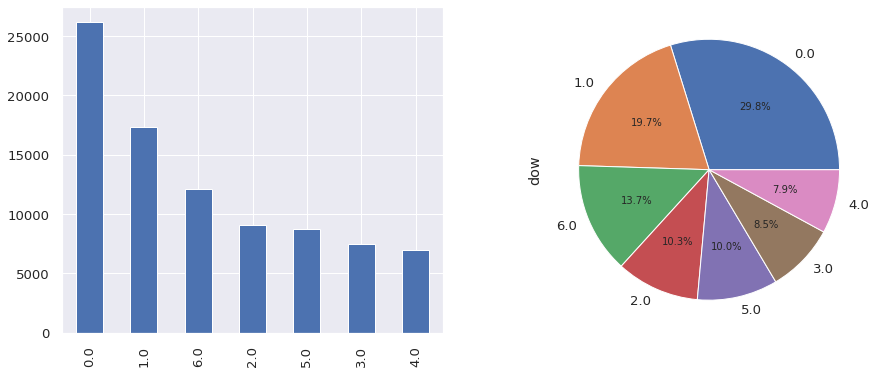

In [ ]:
# 대표 요일 분포
print(f'대표 요일이 있는 유저 수 : {user.dow.count()}') 
f, ax = plt.subplots(1,2,figsize=(15, 6))
user.dow.value_counts().plot.bar(ax=ax[0])
user.dow.value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

대표 시간이 있는 유저 수 : 38548


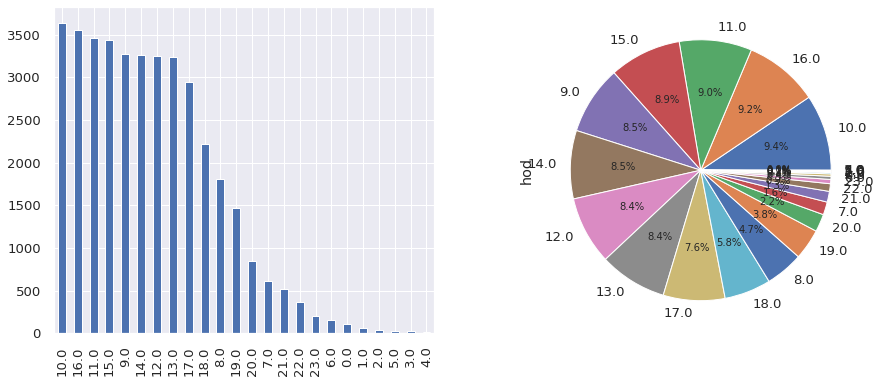

In [ ]:
# 대표 시간 분포
print(f'대표 시간이 있는 유저 수 : {user.hod.count()}')
f, ax = plt.subplots(1,2,figsize=(15, 6))
user.hod.value_counts().plot.bar(ax=ax[0])
user.hod.value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

전체 주문의 40%이상을 새벽 4시에 주문한 유저는 뭘까..?




대표 재주문 기간이 있는 유저 수 : 43278


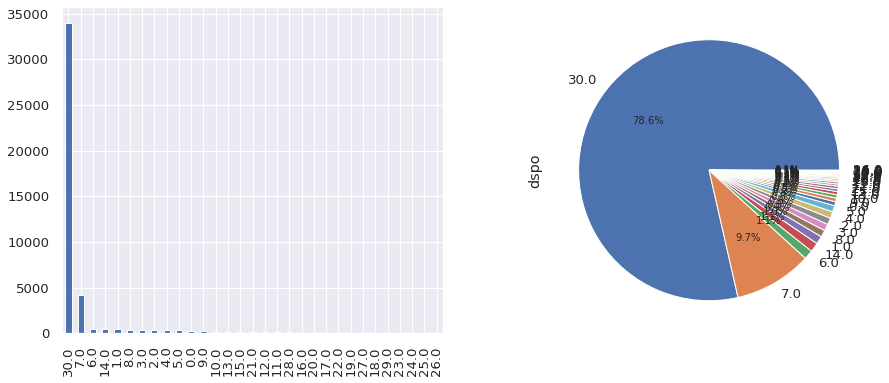

In [ ]:
# 대표 재주문 기간 분포
print(f'대표 재주문 기간이 있는 유저 수 : {user.dspo.count()}')
f, ax = plt.subplots(1,2,figsize=(15, 6))
user.dspo.value_counts().plot.bar(ax=ax[0])
user.dspo.value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

전체 주문의 40% 이상을 특정 재주문 기간 마다 한 4.9만 유저 중 79%는 30일 이상의 간격으로 주문했다. 

아무래도 30일 이상이다 보니까 많이 잡힐 수 있을 것 같다.

9.7%의 유저는 대표 재주문 기간이 7일이다.

In [ ]:
user[user.dspo == 7]

,user_id,dow,hod,dspo
18,39,0.0,NaN,7.0
62,143,5.0,20.0,7.0
81,191,3.0,NaN,7.0
95,214,1.0,NaN,7.0
99,223,1.0,8.0,7.0
...,...,...,...,...
111118,198536,NaN,NaN,7.0
111424,203540,NaN,NaN,7.0
111427,203603,NaN,NaN,7.0
111467,204271,NaN,NaN,7.0


# 유저의 구매제품 별 구매패턴 

유저별로 구매하는 제품마다 패턴있는지 확인

In [ ]:
# 요일, 시간, 재주문 기간 집계
def show_order_dist(user_id=None, product_name=None, aisle=None, department=None):
    f, ax = plt.subplots(1,3,figsize=(15, 6))
    if user_id and product_name:
        f.suptitle(f'{user_id} & {product_name}')
        df[(df.user_id == user_id) & (df.product_name == product_name)]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        df[(df.user_id == user_id) & (df.product_name == product_name)]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        df[(df.user_id == user_id) & (df.product_name == product_name)]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        plt.show()
    elif user_id and aisle:
        f.suptitle(f'{user_id} & {aisle}')
        df[(df.user_id == user_id) & (df.aisle == aisle)]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        df[(df.user_id == user_id) & (df.aisle == aisle)]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        df[(df.user_id == user_id) & (df.aisle == aisle)]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        plt.show()
    elif user_id and department:
        f.suptitle(f'{user_id} & {department}')
        df[(df.user_id == user_id) & (df.department == department)]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        df[(df.user_id == user_id) & (df.department == department)]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        df[(df.user_id == user_id) & (df.department == department)]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        plt.show()
    
    # 유저별로 주문의 요일, 시간, 재주문 기간의 분포를 확인한다. 
    # orders로 찍어봐야 정확하게 알 수 있다. 
    elif user_id:
        
        print(f'{user_id}번 유저의 총 주문 수 : {df[df.user_id == user_id].order_number.max()}')
        prod_list = list(df[df.user_id == user_id].product_name.unique())
        len_prod_list = len(prod_list)
        print(f'{user_id}번 유저가 구매한 제품 수 : {len_prod_list}\n')

        # 제품 목록 보기
        # print('<제품 목록>')
        # for i in range(len_prod_list):
        #     print(prod_list[i], end=' / ')
        #     if i % 4 == 1:
        #         print()
        # print()

        print('<주문 요일, 시간, 재주문 기간 비율>')
        orders_prior = orders[orders.eval_set == 'prior']
        orders_prior[orders_prior.user_id == user_id]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        ax[0].set_title('order_dow')
        ax[0].set_ylabel('')
        orders_prior[orders_prior.user_id == user_id]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        ax[1].set_title('order_hour_of_day')
        ax[1].set_ylabel('')
        orders_prior[orders_prior.user_id == user_id]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        ax[2].set_title('days_since_prior_order')
        ax[2].set_ylabel('')
        plt.show()

        f, ax = plt.subplots(1,2,figsize=(12, 7))
        # 상품 분류 분포
        print('<유저의 구매 제품의 소분류, 대분류 비율>')
        df[df.user_id == user_id]['aisle'].value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[0])
        ax[0].set_title('aisle')
        ax[0].set_ylabel('')
        df[df.user_id == user_id]['department'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        ax[1].set_title('department')
        ax[1].set_ylabel('')
        plt.show()

    elif product_name:
        f.suptitle(product_name)
        df[df.product_name == product_name]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        df[df.product_name == product_name]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        df[df.product_name == product_name]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        plt.show()
    elif aisle:
        f.suptitle(aisle)
        df[df.aisle == aisle]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        df[df.aisle == aisle]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        df[df.aisle == aisle]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        plt.show()
    elif department:
        f.suptitle(department)
        df[df.department == department]['order_dow'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
        df[df.department == department]['order_hour_of_day'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
        df[df.department == department]['days_since_prior_order'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2])
        plt.show()

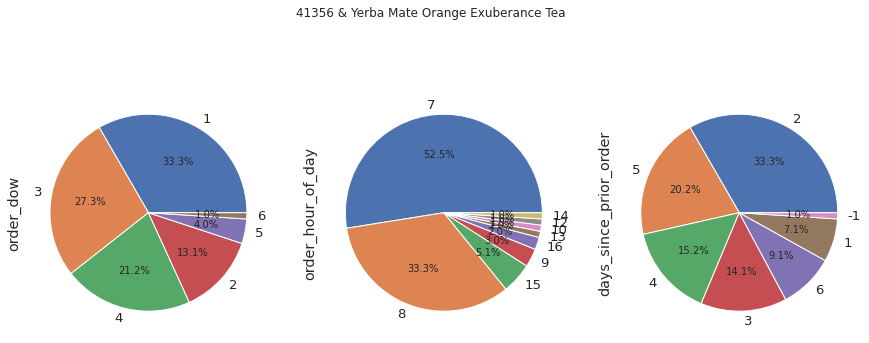

In [ ]:
show_order_dist(user_id=41356, product_name='Yerba Mate Orange Exuberance Tea')

47624번 유저의 총 주문 수 : 50
47624번 유저가 구매한 제품 수 : 176

<주문 요일, 시간, 재주문 기간 비율>


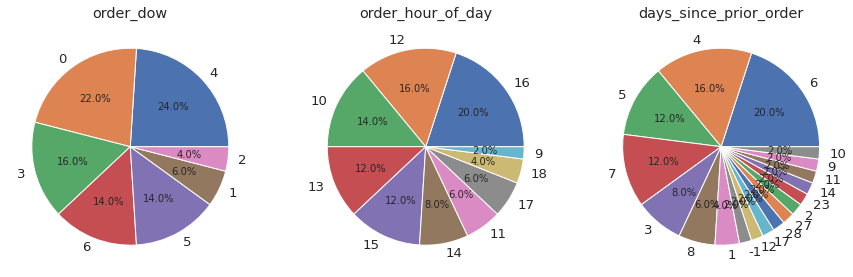

<유저의 구매 제품의 소분류, 대분류 비율>


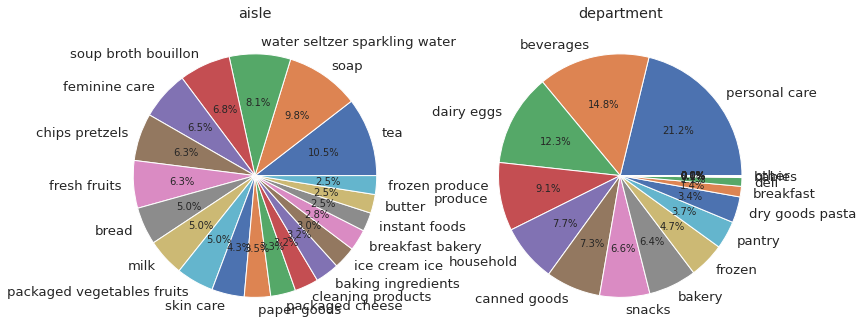

In [ ]:
show_order_dist(user_id=47624)

In [ ]:
df.head()

,user_id,order_number,product_name,user_buy_product_times,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,order_id,product_id,aisle_id,aisle,department_id,department,eval_set
0,1,1,Soda,1,1,0,2,8,-1,2539329,196,77,soft drinks,7,beverages,prior
1,1,1,Organic Unsweetened Vanilla Almond Milk,1,2,0,2,8,-1,2539329,14084,91,soy lactosefree,16,dairy eggs,prior
2,1,1,Original Beef Jerky,1,3,0,2,8,-1,2539329,12427,23,popcorn jerky,19,snacks,prior
3,1,1,Aged White Cheddar Popcorn,1,4,0,2,8,-1,2539329,26088,23,popcorn jerky,19,snacks,prior
4,1,1,XL Pick-A-Size Paper Towel Rolls,1,5,0,2,8,-1,2539329,26405,54,paper goods,17,household,prior


# 재주문 기간별 주문 특징

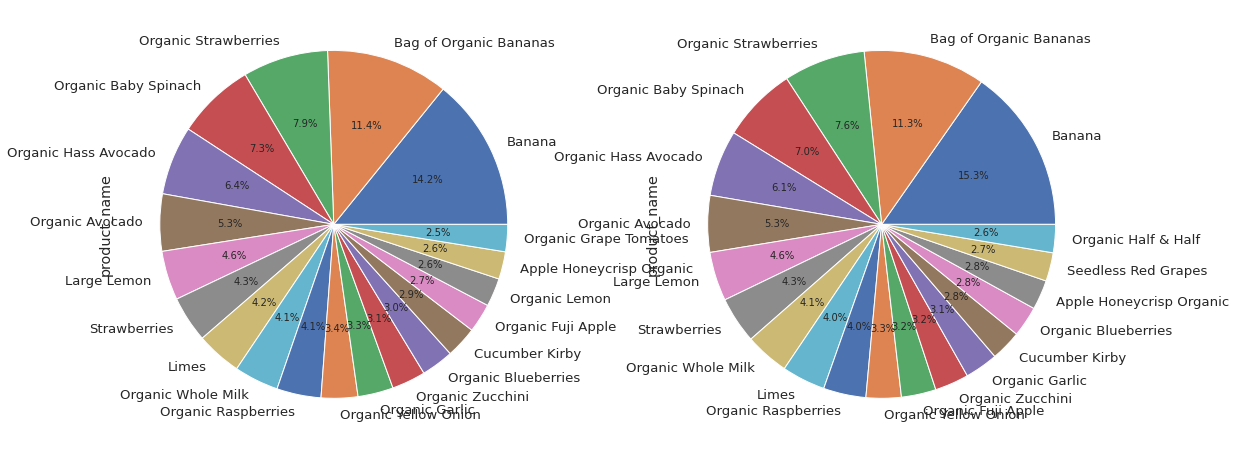

In [ ]:
# 전체 제품 판매량과 재주문 기간 7일 주문의 제품 판매량 
f, ax = plt.subplots(1,2, figsize=(18, 8))
df.product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[0])
df[df.days_since_prior_order == 7].product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

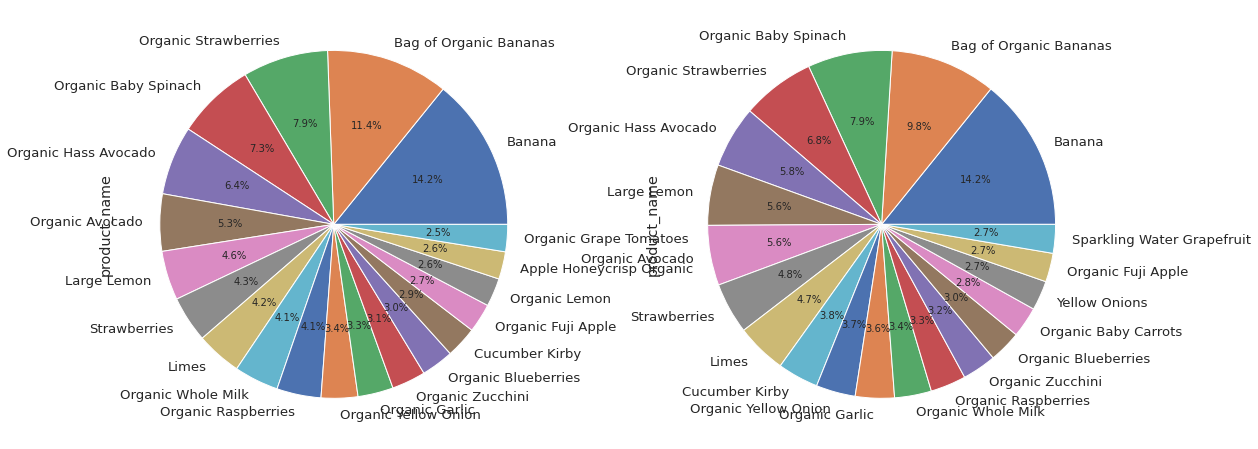

In [ ]:
# 전체 제품 판매량과 재주문 기간 30일 주문의 제품 판매량 
f, ax = plt.subplots(1,2, figsize=(18, 8))
df.product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[0])
df[df.days_since_prior_order == 30].product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

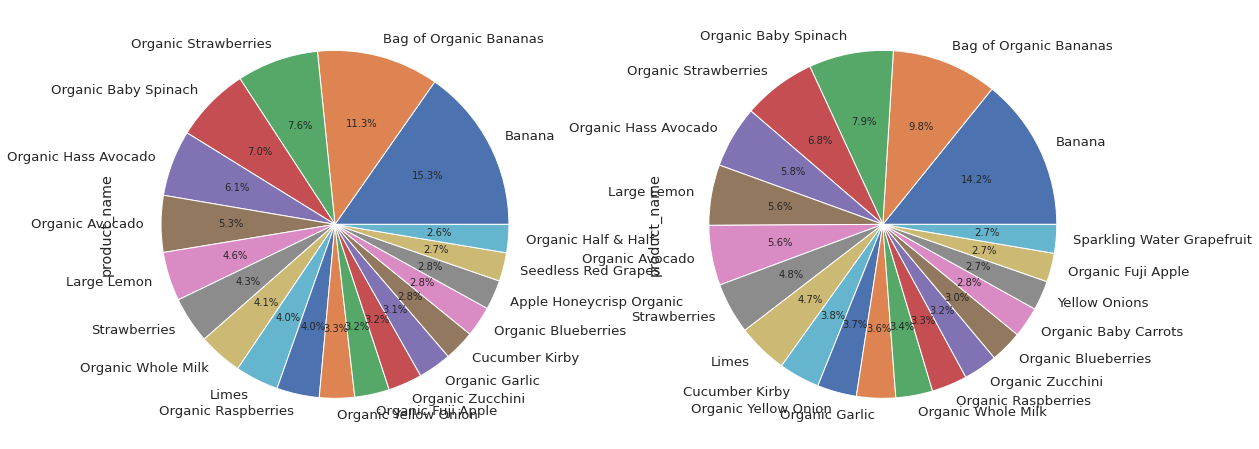

In [ ]:
# 재주문 기간 7일 주문과 재주문 기간 30일 주문의 제품 판매량 
f, ax = plt.subplots(1,2, figsize=(18, 8))
df[df.days_since_prior_order == 7].product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[0])
df[df.days_since_prior_order == 30].product_name.value_counts().head(20).plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

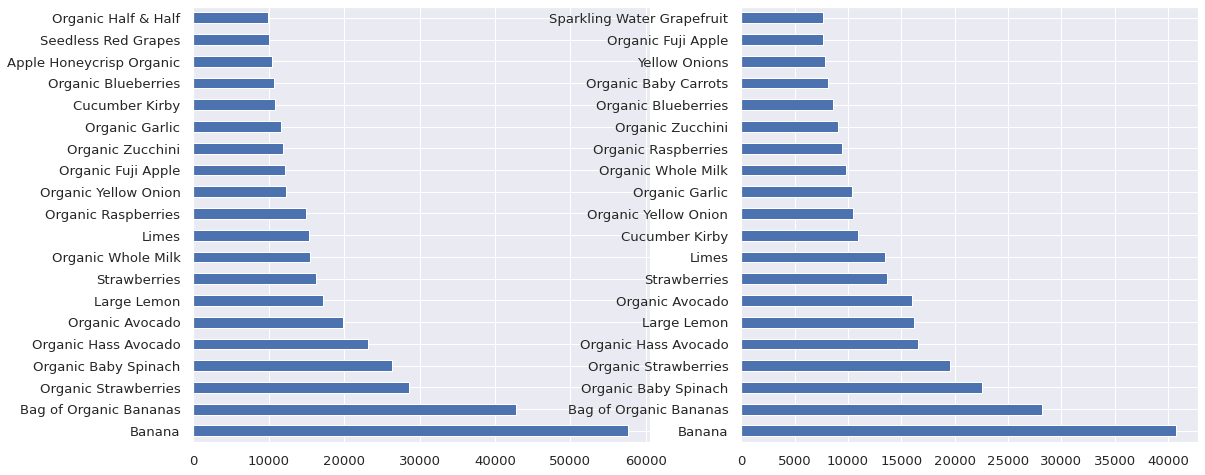

In [ ]:
# 재주문 기간 7일 주문과 재주문 기간 30일 주문의 제품 판매량 
f, ax = plt.subplots(1,2, figsize=(18, 8))
df[df.days_since_prior_order == 7].product_name.value_counts().head(20).plot.barh(ax=ax[0])
df[df.days_since_prior_order == 30].product_name.value_counts().head(20).plot.barh(ax=ax[1])
plt.show()

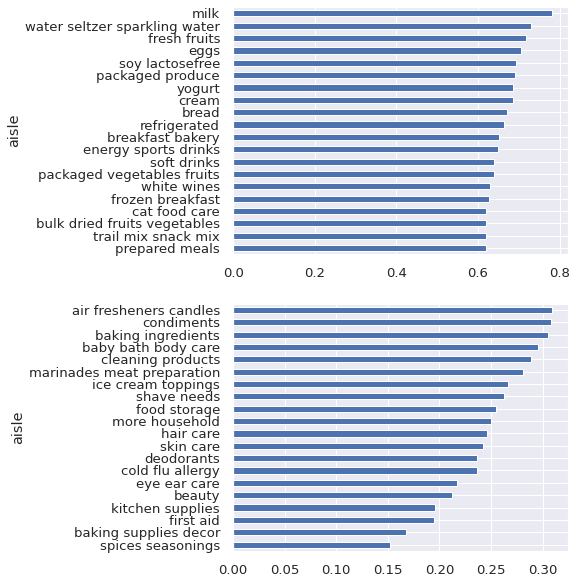

In [ ]:
# aisle 재구매율 상위 20, 하위 20 
f, ax = plt.subplots(2,1,figsize=(6, 10))
df.groupby('aisle')['reordered'].mean().sort_values(ascending=False)[:20][::-1].plot.barh(ax=ax[0])
df.groupby('aisle')['reordered'].mean().sort_values().head(20).plot.barh(ax=ax[1])
plt.show()

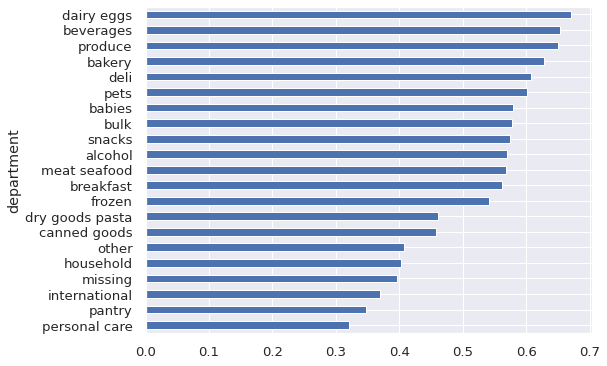

In [ ]:
# department 재구매율
plt.figure(figsize=(8, 6))
df.groupby('department')['reordered'].mean().sort_values(ascending=False)[::-1].plot.barh()
plt.show()

In [ ]:
df[df.department == 'personal care'].groupby('user_id')['product_id'].count().sort_values()[::-1]

user_id
47624     166
94758     161
6626      152
166182    144
23832     142
         ... 
102840      1
102839      1
102816      1
102813      1
2           1
Name: product_id, Length: 93969, dtype: int64

# 기본 정보

- 총 유저 수 : 206,209
- 총 주문 수 : 3,421,083
- 마지막 주문 중 64%는 훈련데이터, 36%는 테스트 데이터다. (131,209),(75,000)
- 유저별 최소 주문 수 4 / 최대 주문 수 100 / 평균 16.6
- 전체 판매 제품 수 : 32,434,489
- 주문당 평균 구매 제품 수 : 10
- 총 제품 수 : 49,688

In [ ]:
top_ten = int(prod_feats.shape[0] * 0.1) # 4967
prod_feats.head(top_ten)['P_total_orders'].sum() / df.shape[0]

0.8143072024350376

전체 판매량의 81%는 10%의 제품에서 나온다.



In [ ]:
total_users = df.user_id.nuique()
total_orders = df.order_id.nunique()
total_products = 

총 판매량 3200만 (전체 주문 별 제품 수의 합)

주문수 340만 (전체 유저 별 주문 수의 합)

유저수 20만

총 제품 종류 수 5만



## 시간, 요일

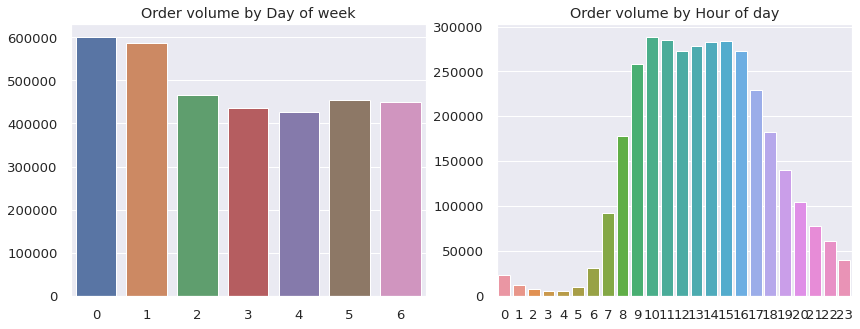

In [ ]:
f, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].set_title('Order volume by Day of week')
sns.barplot(orders.order_dow.value_counts().index, orders.order_dow.value_counts().values, ax=ax[0])
ax[1].set_title('Order volume by Hour of day')
sns.barplot(orders.order_hour_of_day.value_counts().index, orders.order_hour_of_day.value_counts().values, ax=ax[1])
plt.show()

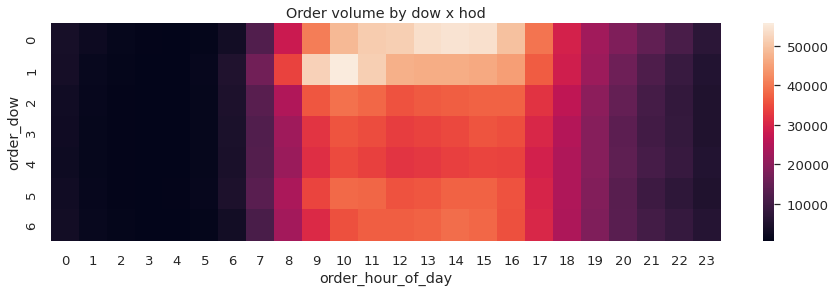

In [ ]:
data = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].count().reset_index().pivot(index='order_dow', columns='order_hour_of_day', values='order_id')
plt.figure(figsize=(15,4))
plt.title('Order volume by dow x hod')
sns.heatmap(data)
plt.show()

요일 : 0과 1이 주문량이 많다. (아마 주말)

시간 : 사람들이 주로 활동하는 시간 9 ~ 17까지 주문이 가장 많다.

요일, 시간 : 0번 요일 13~15시와 1번 요일 10시가 가장 주문이 많은 것을 볼 수 있다. 

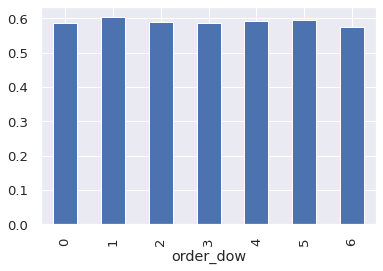

In [ ]:
df.groupby('order_dow')['reordered'].mean().plot.bar()
plt.show()

요일별 재주문율은 차이가 거의 없다.

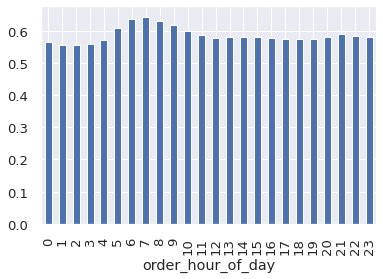

In [ ]:
df.groupby('order_hour_of_day')['reordered'].mean().plot.bar()
plt.show()

시간별 재주문율은 

### 시간과 요일별 판매 제품 차이

시간과 요일에 따라 판매되는 제품에 어떤 차이가 있을까?

## 재주문 기간

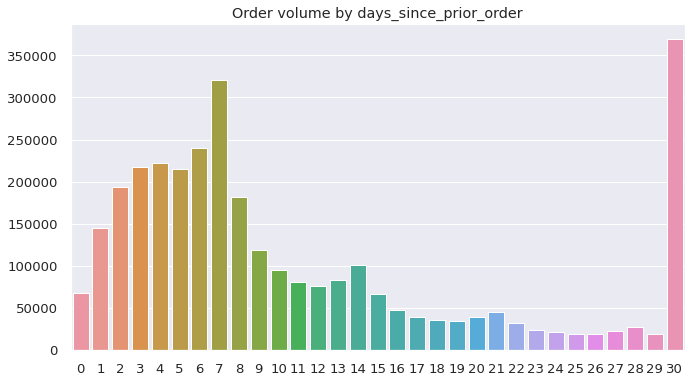

In [ ]:
data = orders[orders.days_since_prior_order > -1].days_since_prior_order.value_counts()
plt.figure(figsize=(11, 6))
sns.barplot(x=data.index, y=data.values)
plt.title('Order volume by days_since_prior_order')
plt.show()

30일 이상 주문이 가장 많다. 7일 단위로 주문량이 튀는 것을 볼 수 있다. 

## 제품

In [ ]:
# 재주문된 제품 수
df[df.reordered == 1].drop_duplicates('product_id').shape[0]

45305

In [ ]:
df.reordered.sum() / df[df.reordered == 1].drop_duplicates('product_id').shape[0]

422.17274031563846

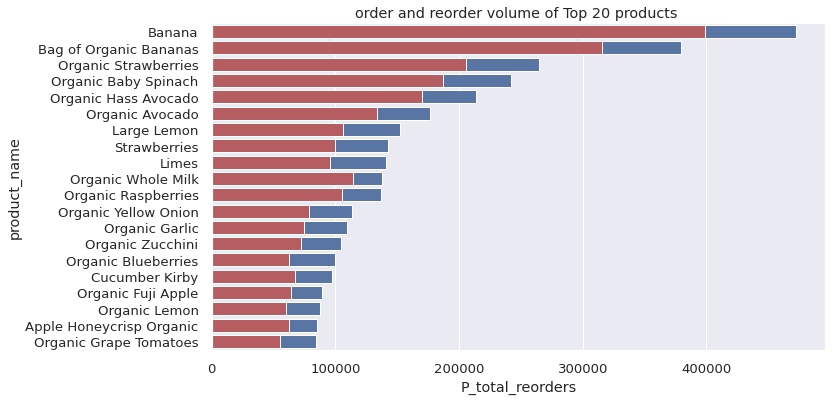

In [ ]:
plt.figure(figsize=(11, 6))
plt.title('order and reorder volume of Top 20 products ')
sns.barplot(x='P_total_orders', y='product_name', data=prod_feats.head(20), color=color[0])
sns.barplot(x='P_total_reorders', y='product_name', data=prod_feats.head(20), color=color[3])
plt.show()

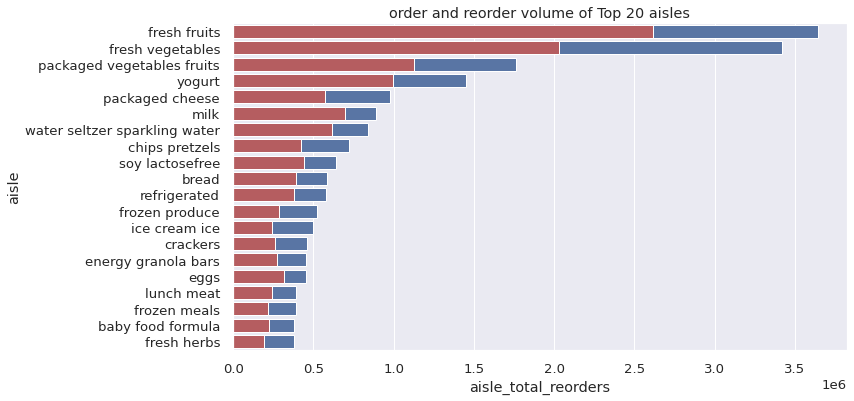

In [ ]:
aisles = prod_feats[['aisle', 'aisle_total_orders', 'aisle_total_reorders', 'aisle_reorder_rate', 'aisle_avg_cart_order']].drop_duplicates('aisle').sort_values('aisle_total_orders')[::-1]
plt.figure(figsize=(11, 6))
plt.title('order and reorder volume of Top 20 aisles')
sns.barplot(x='aisle_total_orders', y='aisle', data=aisles.head(20), color=color[0])
sns.barplot(x='aisle_total_reorders', y='aisle', data=aisles.head(20), color=color[3])
plt.show()

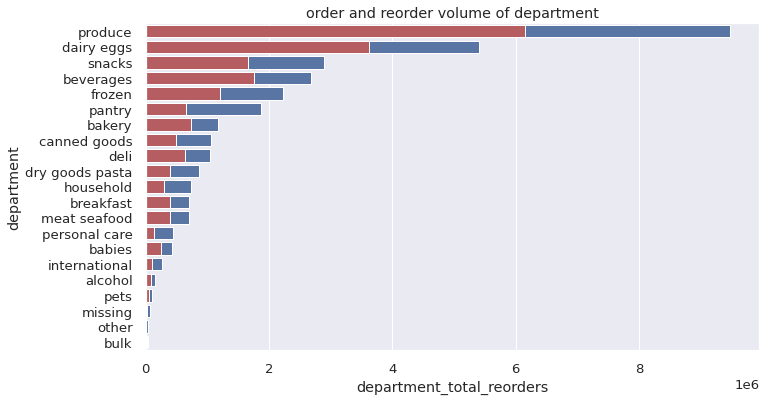

In [ ]:
departments = prod_feats[['department', 'department_total_orders', 'department_total_reorders', 'department_reorder_rate', 'department_avg_cart_order']].drop_duplicates('department').sort_values('department_total_orders')[::-1]
plt.figure(figsize=(11, 6))
plt.title('order and reorder volume of department')
sns.barplot(x='department_total_orders', y='department', data=departments, color=color[0])
sns.barplot(x='department_total_reorders', y='department', data=departments, color=color[3])
plt.show()

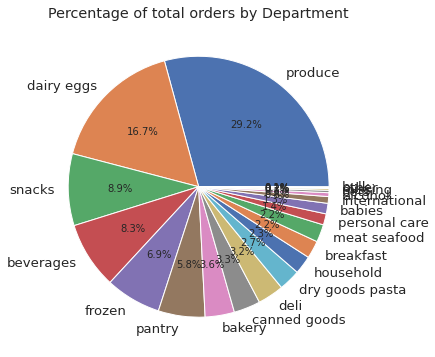

In [ ]:
plt.figure(figsize=(11, 6))
plt.title('Percentage of total orders by Department')
df.department.value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

농작물과 유제품/달걀류 제품이 전체 판매량에서 45.9%를 차지한다.

그 다음으로 과자와 음료, 냉동식품, 가공식품이 뒤를 잇는다. 

농작물, 유제품/달걀류는 짧은 유통기한이 판매량에 영향을 미칠 것 같다. 

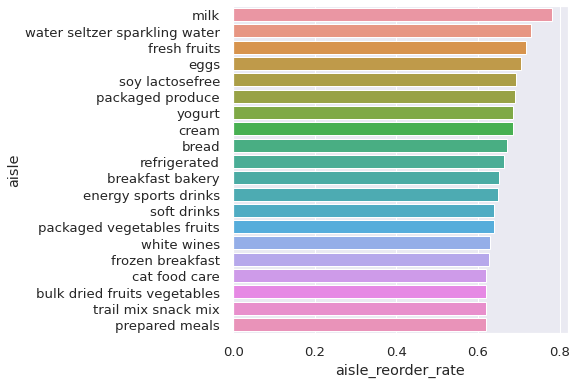

In [ ]:
# aisle 재주문율 top 20
plt.figure(figsize=(6,6))
sns.barplot(x='aisle_reorder_rate', y='aisle', data=aisles.sort_values('aisle_reorder_rate')[::-1].head(20))
plt.show()

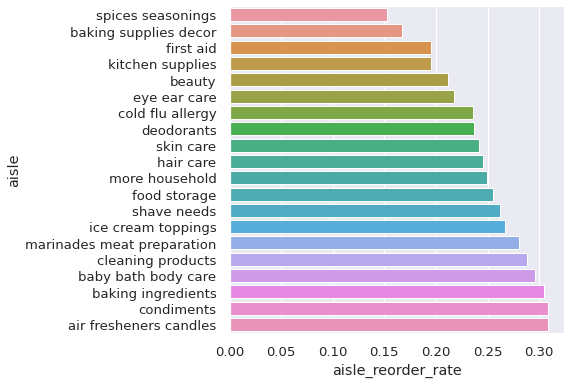

In [ ]:
# aisle 재주문율 하위 20
plt.figure(figsize=(6,6))
sns.barplot(x='aisle_reorder_rate', y='aisle', data=aisles.sort_values('aisle_reorder_rate').head(20))
plt.show()

재주문율의 차이가 큰 이유 찾아보기

1. 

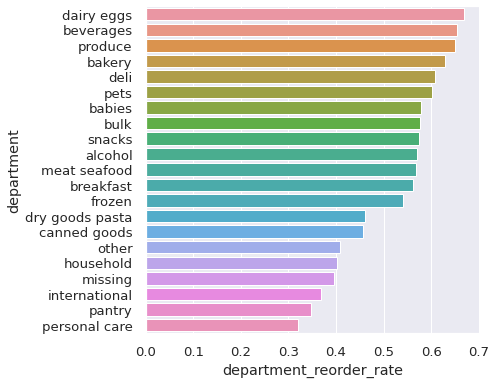

In [ ]:
# departments 재주문율
plt.figure(figsize=(6,6))
sns.barplot(x='department_reorder_rate', y='department', data=departments.sort_values('department_reorder_rate')[::-1])
plt.show()

In [ ]:
df.groupby('user_id')['is_organic'].mean().sort_values()[::-1]

user_id
174291    1.0
55878     1.0
8948      1.0
161526    1.0
85134     1.0
         ... 
167661    0.0
177335    0.0
145825    0.0
145815    0.0
99024     0.0
Name: is_organic, Length: 206209, dtype: float64

In [ ]:
df.groupby('is_organic').reordered.mean()

is_organic
0    0.568799
1    0.634926
Name: reordered, dtype: float64

유기농 제품의 재주문율은 63%이다.

In [ ]:
df.groupby('is_lowfat').reordered.mean()

is_lowfat
0    0.584969
1    0.700573
Name: reordered, dtype: float64

low fat제품의 재주문율은 70%이다.

In [ ]:
# df['is_organic'] = df.product_name.apply(lambda x: 1 if 'Organic' in x else 0)
df['is_lowfat'] = df.product_name.apply(lambda x: 1 if 'fat' in x or 'Fat' in x else 0)

In [ ]:
prod_feats.head()

,product_name,P_total_orders,P_unique_users,P_total_reorders,P_reorder_rate,P_mean_cart_order,is_organic,is_low_fat,product_id,aisle,...,aisle_id,department_id,aisle_total_orders,aisle_total_reorders,aisle_reorder_rate,aisle_avg_cart_order,department_total_orders,department_total_reorders,department_reorder_rate,department_avg_cart_order
0,Banana,472565,73956,398609.0,0.843501,4.894129,0,0,24852,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875
1,Bag of Organic Bananas,379450,63537,315913.0,0.832555,5.095947,1,0,13176,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875
2,Organic Strawberries,264683,58838,205845.0,0.777704,7.248902,1,0,21137,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875
3,Organic Baby Spinach,241921,55037,186884.0,0.772500,7.429640,1,0,21903,packaged vegetables fruits,...,123,4,1765313,1127177.0,0.638514,8.399527,9479291,6160710.0,0.649913,8.022875
4,Organic Hass Avocado,213584,43453,170131.0,0.796553,6.775011,1,0,47209,fresh fruits,...,24,4,3642188,2615469.0,0.718104,7.144228,9479291,6160710.0,0.649913,8.022875


## 장바구니 순위

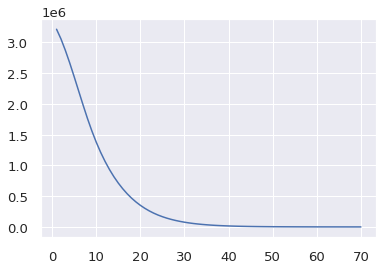

In [ ]:
# 장바구니 순위 수
df.add_to_cart_order.value_counts().head(70).plot()
plt.show()

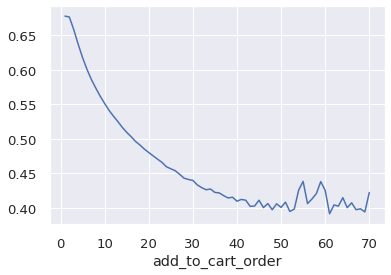

In [ ]:
# 장바구니 순위별 재구매 율
df.groupby('add_to_cart_order')['reordered'].mean().head(70).plot()
plt.show()

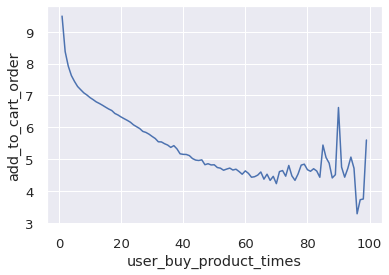

In [ ]:
# 구매횟수별 장바구니 우선순위의 변화
df.groupby('user_buy_product_times')['add_to_cart_order'].mean().plot()
plt.ylabel('add_to_cart_order')
plt.show()

제품의 구매횟수가 늘어갈 수록 장바구니 우선 순위가 높아지는 것을 확인할 수 
있다. 

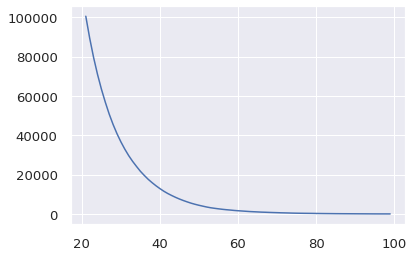

In [ ]:
df.user_buy_product_times.value_counts()[20:].plot()

## 재주문 여부

## 유저별

유저를 어떤 유형으로 묶을 수 있을까?

In [ ]:
def plot_user_prods(user_id):
    for column in ['product_name', 'aisle', 'department']:
        plt.title(column)
        df[df.user_id == user_id].astype({column:np.object0})[column].value_counts().plot.pie(autopct='%1.1f%%')
        plt.ylabel('')
        print()
        plt.show()

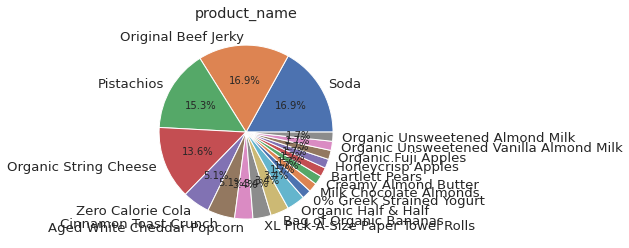

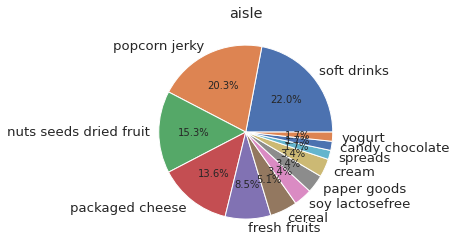

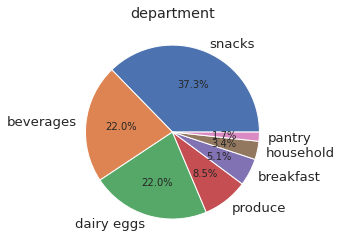

In [ ]:
plot_user_prods(1)

In [ ]:
user_prod_feats.head()

,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,product_name,aisle,department,aisle_id,department_id,U_total_products
0,1,196,9,1.400000,1,1,1,1.00,Soda,soft drinks,beverages,77,7,59
1,1,12427,9,3.300000,1,1,1,1.00,Original Beef Jerky,popcorn jerky,snacks,23,19,59
2,1,10258,8,3.333333,1,1,1,1.00,Pistachios,nuts seeds dried fruit,snacks,117,19,59
3,1,25133,7,4.000000,1,1,1,1.00,Organic String Cheese,packaged cheese,dairy eggs,21,16,59
4,1,13032,2,6.333333,1,-1,-1,0.25,Cinnamon Toast Crunch,cereal,breakfast,121,14,59


In [ ]:
user_feats[user_feats.U_total_orders == 30] 

,user_id,U_total_orders,U_total_products,U_unique_products,U_total_reorders,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1
280,281,30,303,124,179.0,62.0,10.100000,0.622723,16.0,19.0,18.0,0.875000,0.894737,0.666667
605,606,30,172,101,71.0,29.0,5.733333,0.484536,4.0,2.0,10.0,0.500000,1.000000,0.700000
656,657,30,319,189,130.0,55.0,10.633333,0.371697,4.0,12.0,7.0,0.500000,0.666667,0.571429
857,858,30,62,20,42.0,11.0,2.066667,0.764368,2.0,1.0,2.0,1.000000,1.000000,0.500000
1140,1141,30,220,123,97.0,46.0,7.333333,0.427392,4.0,6.0,2.0,1.000000,1.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205562,205563,30,333,139,194.0,68.0,11.100000,0.641099,8.0,8.0,12.0,1.000000,0.750000,0.750000
205654,205655,30,86,16,70.0,12.0,2.866667,0.818391,2.0,5.0,3.0,1.000000,0.800000,1.000000
205665,205666,30,520,110,410.0,63.0,17.333333,0.820365,31.0,25.0,24.0,0.806452,0.920000,1.000000
205793,205794,30,77,15,62.0,10.0,2.566667,0.850575,2.0,6.0,1.0,1.000000,0.833333,1.000000


## 유저별 구매내역

In [ ]:
user_prod_feats.head()

,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,product_name,aisle,department,aisle_id,department_id
0,1,196,9,1.400000,1,1,1,1.00,Soda,soft drinks,beverages,77,7
1,1,12427,9,3.300000,1,1,1,1.00,Original Beef Jerky,popcorn jerky,snacks,23,19
2,1,10258,8,3.333333,1,1,1,1.00,Pistachios,nuts seeds dried fruit,snacks,117,19
3,1,25133,7,4.000000,1,1,1,1.00,Organic String Cheese,packaged cheese,dairy eggs,21,16
4,1,13032,2,6.333333,1,-1,-1,0.25,Cinnamon Toast Crunch,cereal,breakfast,121,14


# 재주문 분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.2)
%matplotlib inline
color = sns.color_palette()

# PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정
PATH = '/content/drive/MyDrive/data/EDA_5.30/' # csv파일이 들어있는 폴더 경로 지정

In [ ]:
# priors = pd.read_csv(PATH + 'order_products__prior.csv', dtype={
#             'order_id': np.uint32,          # 1 ~ 3421083
#             'product_id': np.uint16,        # 1 ~ 49688
#             'add_to_cart_order': np.uint8,  # 1 ~ 80 
#             'reordered': np.uint8})         # 0 ~ 1
# orders = pd.read_csv(PATH + 'orders.csv', dtype={
#         'order_id': np.uint32,              # 1 ~ 3421083
#         'user_id': np.uint32,               # 1 ~ 206209
#         'eval_set': 'category',             # 3가지
#         'order_number': np.uint8,           # 1 ~ 100
#         'order_dow': np.uint8,              # 0 ~ 6 
#         'order_hour_of_day': np.uint8,      # 0 ~ 23
#         'days_since_prior_order': np.float32})
# products = pd.read_csv(PATH + 'products.csv', dtype={
#         'product_id': np.uint16,     # 1 ~ 49688
#         'aisle_id': np.uint8,        # 1 ~ 134
#         'department_id': np.uint8}) # 1 ~ 21
# aisles = pd.read_csv(PATH + 'aisles.csv', dtype={
#         'product_id': np.uint16})     # 1 ~ 49688
# departments = pd.read_csv(PATH + 'departments.csv', dtype={
#         'product_id': np.uint16})
# train = pd.read_csv(PATH + 'order_products__train.csv', dtype={
#             'order_id': np.uint32,          # 1 ~ 3421083
#             'product_id': np.uint16,        # 1 ~ 49688
#             'add_to_cart_order': np.uint8,  # 1 ~ 80 
#             'reordered': np.uint8})         # 0 ~ 1

In [2]:
def reduce_memory(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [2]:
prior_df = pd.read_pickle(PATH + 'prior_df.pkl')

In [3]:
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


일단 유저별 구매내역을 뽑아서 최소한의 피쳐만 넣고 분석을 해본다.

- 평균 장바구니 순위
- 총 구매 수
- 총 재구매 수
- 제품을 주문한 요일, 시간, 재주문 기간

In [ ]:
# products = pd.read_pickle(PATH + 'products.pkl')
# prior_df = priors.merge(orders, on='order_id', how='left')
# prior_df.to_pickle(PATH + 'prior_df.pkl')

# df = prior_df.merge(products, on='product_id', how='left')
# df = df.merge(aisles, on='aisle_id', how='left')
# df = df.merge(departments, on='department_id', how='left')
# df = df.astype({'product_name' : 'category', 'aisle' : 'category', 'department' : 'category'})

# # 유저 X 제품 df생성
# user_prod = prior_df.groupby(['user_id', 'product_id']).agg(mean_add_to_cart_order=('add_to_cart_order', 'mean'), 
#                                                             total_orders=('reordered', 'count'), 
#                                                             total_reorders=('reordered', 'sum')).reset_index()

user_prod['is_organic'] = 
user_prod['is_lowfat'] = 

# # 유저 X 제품 별 주문 요일 생성
# UP_dow = prior_df.groupby(['user_id', 'product_id']).agg(UP_dow=('order_dow','value_counts')).reset_index()
# UP_dow = UP_dow.pivot(index=['user_id', 'product_id'], columns='order_dow', values='UP_dow')
# UP_dow.fillna(0, inplace=True)
# UP_dow.columns = ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
# UP_dow.reset_index(inplace=True)                    

# 유저 X 제품 별 주문 시간 생성
# UP_hod = prior_df.groupby(['user_id', 'product_id']).agg(UP_hod=('order_hour_of_day','value_counts')).reset_index()
# UP_hod = UP_hod.pivot(index=['user_id', 'product_id'], columns='order_hour_of_day', values='UP_hod')
# UP_hod.fillna(0, inplace=True)
# UP_hod.columns = ['hod_0', 'hod_1', 'hod_2', 'hod_3', 'hod_4', 'hod_5', 'hod_6', 'hod_7', 'hod_8', 
#                   'hod_9', 'hod_10', 'hod_11', 'hod_12', 'hod_13', 'hod_14', 'hod_15', 'hod_16', 
#                   'hod_17', 'hod_18', 'hod_19', 'hod_20', 'hod_21', 'hod_22', 'hod_23']
# UP_hod.reset_index(inplace=True)

# # 유저 X 제품 별 재주문 기간 생성
# UP_dspo = prior_df.groupby(['user_id', 'product_id']).agg(UP_dspo=('days_since_prior_order','value_counts')).reset_index()
# UP_dspo = UP_dspo.pivot(index=['user_id', 'product_id'], columns='days_since_prior_order', values='UP_dspo')
# UP_dspo.fillna(0, inplace=True)
# UP_dspo.columns = ['dspo_0', 'dspo_1', 'dspo_2', 'dspo_3', 'dspo_4', 'dspo_5', 'dspo_6', 'dspo_7', 'dspo_8', 
#                   'dspo_9', 'dspo_10', 'dspo_11', 'dspo_12', 'dspo_13', 'dspo_14', 'dspo_15', 'dspo_16', 
#                   'dspo_17', 'dspo_18', 'dspo_19', 'dspo_20', 'dspo_21', 'dspo_22', 'dspo_23', 
#                    'dspo_24', 'dspo_25', 'dspo_26', 'dspo_27', 'dspo_28', 'dspo_29', 'dspo_30']
# UP_dspo.reset_index(inplace=True)

# # 병합
# user_prod = user_prod.merge(UP_dow, on=['user_id', 'product_id'], how='left')
# user_prod = user_prod.merge(UP_hod, on=['user_id', 'product_id'], how='left')
# user_prod = user_prod.merge(UP_dspo, on=['user_id', 'product_id'], how='left')
# user_prod = user_prod.merge(products, on='product_id', how='left')
# # 마지막 주문 정보 병합
# user_prod = user_prod.merge(orders[orders.eval_set != 'prior'].drop('eval_set', axis=1).rename(columns={'order_number':'last_order_number', 
#                                                                             'order_dow':'last_order_dow', 
#                                                                             'order_hour_of_day':'last_order_hour_of_day', 
#                                                                             'days_since_prior_order':'last_days_since_prior_order', 
#                                                                             'order_id':'last_order_id'}), on='user_id', how='left')

# # 데이터 용량 줄이고 저장
# reduce_memory(user_prod)
# user_prod.to_pickle(PATH + 'user_prod.pkl')

Memory usage of properties dataframe is : 2360.6102542877197  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  2360.6102542877197  MB
This is  100.0 % of the initial size


훈련데이터와 테스트 데이터 나누기

훈련데이터에는 타겟값 생성

In [ ]:
user_prod = pd.read_pickle(PATH + 'user_prod.pkl')
orders = pd.read_pickle(PATH + 'orders.pkl')
train = pd.read_pickle(PATH + 'train_products.pkl')

In [ ]:
# # 1. train, test 셋 유저 명단 뽑기 
# train_users = orders[orders.eval_set == 'train'].user_id.unique() 
# test_users = orders[orders.eval_set == 'test'].user_id.unique() 

# # 2. train, test set 분리
# train_df = user_prod[user_prod['user_id'].isin(train_users)]
# test_df = user_prod[user_prod['user_id'].isin(test_users)]

# # 3. train_df에 타겟값 추가
# train_df = train_df.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id','product_id'], how='left') 
# train_df['reordered'].fillna(0, inplace=True)
# train_df = train_df.astype({'reordered': np.uint8})

# train_df.sort_values(by=['user_id', 'total_orders'], ascending=[True, False], inplace=True, ignore_index=True)

# # 컬럼 순서 보기 좋게 변경
# train_df = train_df[train_df.columns[:2].to_list() + train_df.columns[-1:].to_list() + train_df.columns[2:-1].to_list()]

# train_df.to_pickle(PATH + 'train_df.pkl')
# test_df.to_pickle(PATH + 'test_df.pkl')

In [3]:
train_df = pd.read_pickle(PATH + 'train_df.pkl')
test_df = pd.read_pickle(PATH + 'test_df.pkl')

훈련 데이터

총 유저 수 : 131,209


In [ ]:
train_df.head()

,user_id,product_id,reordered,mean_add_to_cart_order,total_orders,total_reorders,dow_0,dow_1,dow_2,dow_3,...,product_name,aisle,department,aisle_id,department_id,last_order_number,last_order_dow,last_order_hour_of_day,last_days_since_prior_order,last_order_id
0,1,196,1,1.400391,10,9,0.0,3.0,2.0,2.0,...,Soda,soft drinks,beverages,77,7,11,4,8,14,1187899
1,1,12427,0,3.300781,10,9,0.0,3.0,2.0,2.0,...,Original Beef Jerky,popcorn jerky,snacks,23,19,11,4,8,14,1187899
2,1,10258,1,3.333984,9,8,0.0,3.0,1.0,2.0,...,Pistachios,nuts seeds dried fruit,snacks,117,19,11,4,8,14,1187899
3,1,25133,1,4.000000,8,7,0.0,3.0,1.0,1.0,...,Organic String Cheese,packaged cheese,dairy eggs,21,16,11,4,8,14,1187899
4,1,13032,1,6.332031,3,2,0.0,1.0,0.0,1.0,...,Cinnamon Toast Crunch,cereal,breakfast,121,14,11,4,8,14,1187899


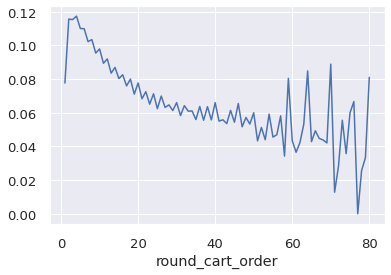

In [ ]:
# 장바구니 순위별 재주문율
# train_df['round_cart_order'] = train_df.mean_add_to_cart_order.round()
train_df.groupby('round_cart_order')['reordered'].mean()[:80].plot()
plt.show()

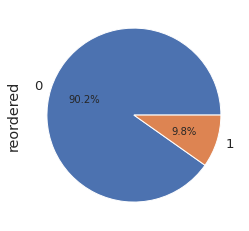

In [ ]:
# 레이블 비율
train_df.reordered.value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

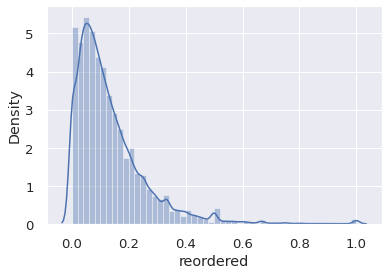

In [11]:
# 유저별 구매내역 중 마지막 주문에서 재주문 상품 비율
sns.distplot(train_df.groupby('user_id')['reordered'].mean())
plt.show()

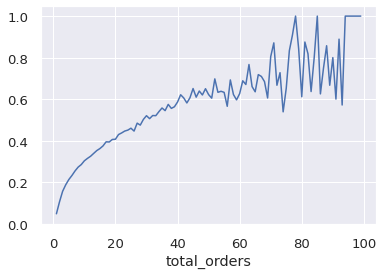

In [ ]:
# 주문 수에 따른 재주문 율
train_df.groupby('total_orders').reordered.mean().plot()
plt.show()

In [ ]:
# 재주문여부에 따른 평균 장바구니 순위
train_df.groupby('reordered').mean_add_to_cart_order.mean()

reordered
0    9.304688
1    8.304688
Name: mean_add_to_cart_order, dtype: float16

In [ ]:
# department별 재주문 율
train_df.groupby('department')['reordered'].mean().sort_values()[::-1]

department
dairy eggs         0.128690
produce            0.128506
beverages          0.126562
missing            0.118146
pets               0.114196
bakery             0.110109
deli               0.104196
meat seafood       0.091813
snacks             0.088504
frozen             0.086078
breakfast          0.085004
alcohol            0.083507
bulk               0.083431
babies             0.070746
dry goods pasta    0.063458
canned goods       0.061757
household          0.054678
other              0.051348
international      0.041863
pantry             0.037791
personal care      0.037539
Name: reordered, dtype: float64

In [ ]:
# aisle별 재주문 율
train_df.groupby('aisle')['reordered'].mean().sort_values()[::-1]

aisle
milk                             0.209169
water seltzer sparkling water    0.186537
packaged produce                 0.177662
eggs                             0.170445
fresh fruits                     0.169402
                                   ...   
first aid                        0.021173
beauty                           0.021106
kitchen supplies                 0.017256
baking supplies decor            0.015201
spices seasonings                0.013352
Name: reordered, Length: 134, dtype: float64

In [ ]:
# department별 평균 장바구니 순위
train_df.groupby('department')['mean_add_to_cart_order'].mean().sort_values()

department
alcohol             6.218750
beverages           8.101562
dairy eggs          8.546875
pets                8.554688
household           8.640625
other               8.742188
produce             8.828125
bakery              8.906250
personal care       8.937500
meat seafood        8.968750
deli                9.414062
bulk                9.421875
breakfast           9.750000
pantry              9.796875
frozen              9.804688
missing             9.906250
snacks              9.960938
international      10.195312
canned goods       10.203125
dry goods pasta    10.437500
babies             11.468750
Name: mean_add_to_cart_order, dtype: float16

In [ ]:
# aisle별 평균 장바구니 순위
train_df.groupby('aisle')['mean_add_to_cart_order'].mean().sort_values()

aisle
specialty wines champagnes     5.667969
spirits                        5.832031
beers coolers                  5.937500
packaged produce               6.015625
white wines                    6.605469
                                ...    
instant foods                 10.593750
fresh pasta                   10.593750
indian foods                  10.687500
salad dressing toppings       10.796875
baby food formula             11.789062
Name: mean_add_to_cart_order, Length: 134, dtype: float16

In [ ]:
# department별 
train_df.groupby('department')['total_orders'].sum().sort_values()[::-1]

department
produce            6038459.0
dairy eggs         3451649.0
snacks             1830236.0
beverages          1714607.0
frozen             1424216.0
pantry             1193665.0
bakery              747555.0
canned goods        679349.0
deli                669536.0
dry goods pasta     552377.0
household           469552.0
breakfast           451496.0
meat seafood        449530.0
personal care       284380.0
babies              270547.0
international       171479.0
alcohol              92605.0
pets                 61222.0
missing              44319.0
other                22684.0
bulk                 22528.0
Name: total_orders, dtype: float64

In [ ]:
train_df.corr()

,user_id,product_id,reordered,mean_add_to_cart_order,total_orders,total_reorders,dow_0,dow_1,dow_2,dow_3,...,dspo_29,dspo_30,aisle_id,department_id,last_order_number,last_order_dow,last_order_hour_of_day,last_days_since_prior_order,last_order_id,round_cart_order
user_id,1.000000,-0.000438,-0.000429,-0.000370,-0.001855,-0.001855,0.000577,-0.000160,-0.000876,-0.003442,...,0.000617,0.002174,0.000029,-0.000012,-0.007158,-0.001668,0.001293,0.005517,-0.003826,-0.000383
product_id,-0.000438,1.000000,0.002786,0.000223,0.003016,0.003016,0.005143,0.002345,0.001077,-0.000102,...,0.001122,0.002399,0.003723,-0.026408,-0.002784,-0.002090,0.001298,0.001517,0.000312,0.000229
reordered,-0.000429,0.002786,1.000000,-0.042599,0.248376,0.248376,0.170073,0.157917,0.146154,0.138328,...,0.043949,0.163295,0.002256,-0.033707,-0.092544,-0.012129,-0.005085,0.042945,0.001226,-0.042588
mean_add_to_cart_order,-0.000370,0.000223,-0.042599,1.000000,-0.085359,-0.085359,-0.036802,-0.047935,-0.062127,-0.067725,...,-0.010661,-0.048563,0.006578,0.026551,0.001382,-0.013399,-0.003796,-0.014836,0.003832,0.999595
total_orders,-0.001855,0.003016,0.248376,-0.085359,1.000000,1.000000,0.600275,0.644665,0.612787,0.592327,...,0.056972,0.110303,0.003565,-0.032730,0.235834,0.003641,-0.010944,-0.119306,0.000654,-0.085352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
last_order_dow,-0.001668,-0.002090,-0.012129,-0.013399,0.003641,0.003641,-0.052915,-0.032350,-0.005903,0.012679,...,-0.003935,-0.017807,-0.001314,0.002773,0.032912,1.000000,0.005525,-0.031233,0.002795,-0.013399
last_order_hour_of_day,0.001293,0.001298,-0.005085,-0.003796,-0.010944,-0.010944,0.013852,-0.024760,-0.016997,-0.011648,...,0.000342,0.012739,0.000805,-0.006879,-0.022815,0.005525,1.000000,-0.001671,-0.004775,-0.003799
last_days_since_prior_order,0.005517,0.001517,0.042945,-0.014836,-0.119306,-0.119306,-0.054046,-0.074201,-0.071196,-0.075767,...,0.046162,0.222222,0.000401,-0.008994,-0.466687,-0.031233,-0.001671,1.000000,0.003906,-0.014827
last_order_id,-0.003826,0.000312,0.001226,0.003832,0.000654,0.000654,0.000294,0.000775,0.000207,0.001116,...,0.001229,0.000823,0.000946,0.001365,-0.004221,0.002795,-0.004775,0.003906,1.000000,0.003838


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.5)
%matplotlib inline
color = sns.color_palette()

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

train_df = pd.read_pickle(PATH + 'train_df.pkl')
test_df = pd.read_pickle(PATH + 'test_df.pkl')

df2 = pd.read_pickle(PATH +'Finaldata.pkl')

In [7]:
train_df

,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,aisle_id,department_id,...,U_unique_reordered_items,U_avg_items_in_order,U_avg_reorder_in_order,prod_order_3,U_prod_order_2,U_prod_order_1,U_re_in_order_3,U_re_in_order_2,U_re_in_order_1,reordered
0,1,196,9,1.400391,1,1,1,1.00,77,7,...,10.0,5.898438,0.784180,6.0,6.0,9.0,0.666504,1.000000,0.666504,1
1,1,12427,9,3.300781,1,1,1,1.00,23,19,...,10.0,5.898438,0.784180,6.0,6.0,9.0,0.666504,1.000000,0.666504,0
2,1,10258,8,3.333984,1,1,1,1.00,117,19,...,10.0,5.898438,0.784180,6.0,6.0,9.0,0.666504,1.000000,0.666504,1
3,1,25133,7,4.000000,1,1,1,1.00,21,16,...,10.0,5.898438,0.784180,6.0,6.0,9.0,0.666504,1.000000,0.666504,1
4,1,13032,2,6.332031,1,-1,-1,0.25,121,14,...,10.0,5.898438,0.784180,6.0,6.0,9.0,0.666504,1.000000,0.666504,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,40310,0,7.000000,0,-1,-1,0.00,96,20,...,24.0,9.921875,0.581543,8.0,20.0,9.0,0.750000,0.700195,0.444336,0
8474657,206209,41665,0,5.000000,-1,-1,-1,0.00,21,16,...,24.0,9.921875,0.581543,8.0,20.0,9.0,0.750000,0.700195,0.444336,0
8474658,206209,44325,0,8.000000,-1,-1,-1,0.00,131,9,...,24.0,9.921875,0.581543,8.0,20.0,9.0,0.750000,0.700195,0.444336,0
8474659,206209,48370,0,8.000000,0,-1,-1,0.00,54,17,...,24.0,9.921875,0.581543,8.0,20.0,9.0,0.750000,0.700195,0.444336,0


In [6]:
df2

,user_id,product_id,total_product_reorders_by_user,user_product_reorder_percentage,total_product_orders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,order_-3,order_-2,...,reorder_propotion_by_user,average_order_size,reorder_in_order,prod_order_3,prod_order_2,prod_order_1,re_in_order_3,re_in_order_2,re_in_order_1,order_diff
0,1.0,196,9.0,0.899902,10.0,1.400391,19.562500,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,1.0,10258,8.0,0.888672,9.0,3.333984,19.562500,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,10326,0.0,0.000000,1.0,5.000000,28.000000,5.0,NaN,NaN,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,1.0,12427,9.0,0.899902,10.0,3.300781,19.562500,10.0,1.0,1.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,1.0,13032,2.0,0.666504,3.0,6.332031,21.671875,10.0,1.0,NaN,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209.0,43961,2.0,0.666504,3.0,8.000000,23.328125,12.0,1.0,NaN,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,206209.0,44325,0.0,0.000000,1.0,8.000000,9.000000,7.0,NaN,NaN,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,206209.0,48370,0.0,0.000000,1.0,8.000000,30.000000,11.0,0.0,NaN,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,206209.0,48697,0.0,0.000000,1.0,6.000000,9.000000,7.0,NaN,NaN,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [9]:
from sklearn.cluster import KMeans

In [ ]:
KMeans.